# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
### Importamos librerias
import gzip
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns



def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

**Reviews**

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('data/steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [3]:
data_reviews = pd.DataFrame(data_reviews)

In [2]:
if True:
    data_reviews.to_csv('data/data_reviews.csv', index= False)

NameError: name 'data_reviews' is not defined

#### Cargamos el dataset

In [2]:
data_reviews = pd.read_csv('data/data_reviews.csv')
data_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,7.656120e+16,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,7.656120e+16,NaN,NaN


We crawled reviews and game information from Steam. The dataset contains 7,793,069 reviews, 2,567,538 users, and 32,135 games. In addition to the review text, the data also includes the users' play hours in each review.

In [3]:
data_reviews.isna().sum()

username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

In [4]:
## Tamaño del dataset
data_reviews.shape

(779307, 12)

In [5]:
### Cantidad de valoraciónes de un juego especifico
data_reviews[data_reviews.product_id == '35140']

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny


**Games**

In [30]:
data_games = []
for l in parse('data/steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [31]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [32]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [11]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [12]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [13]:
## Tamaño del dataset
data_games.shape

(32135, 16)

In [14]:
#Don't drop, just take the rows where EPS is not NA:
data_games = data_games[data_games['id'].notna()]
data_games['id'] = data_games['id'].astype('int')
data_games.reset_index(inplace=True)

#### Realizo merge de los dos dataset

Agregamos al dataset el nombre del Juego

In [2]:
#https://interactivechaos.com/es/manual/tutorial-de-pandas/dataframes-la-funcion-merge
mergeado = pd.merge(data_reviews,data_games, left_on = "product_id", right_on = "id")

NameError: name 'data_reviews' is not defined

In [22]:
if True:
    mergeado.to_csv('data/mergeado.csv', index= False)

In [24]:
df = pd.read_csv('data/mergeado.csv')
df.head(2)

,username,hours,products,product_id,page_order,date,text,early_access_x,page,user_id,...,tags,discount_price,reviews_url,specs,price,early_access_y,id,developer,sentiment,metascore
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,...,"['Action', 'Adventure', 'Indie', 'Simulation']",NaN,http://steamcommunity.com/app/725280/reviews/?...,"['Single-player', 'Steam Trading Cards']",2.99,False,725280,Vyacheslav Shilikhin,Positive,NaN
1,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,...,"['Action', 'Adventure', 'Indie', 'Simulation']",NaN,http://steamcommunity.com/app/725280/reviews/?...,"['Single-player', 'Steam Trading Cards']",2.99,False,725280,Vyacheslav Shilikhin,Positive,NaN


In [4]:
## Tamaño del dataset
df.shape

(779951, 27)

In [4]:
#descarto compensation y found_funny por la gran cantidad de faltantes
#data_reviews.drop(columns=['compensation', 'found_funny'], inplace=False)

In [5]:
#data_reviews.isna().sum()

In [6]:
#data_reviews.info()

#### Pairplot para ver la distribución de todas las variables

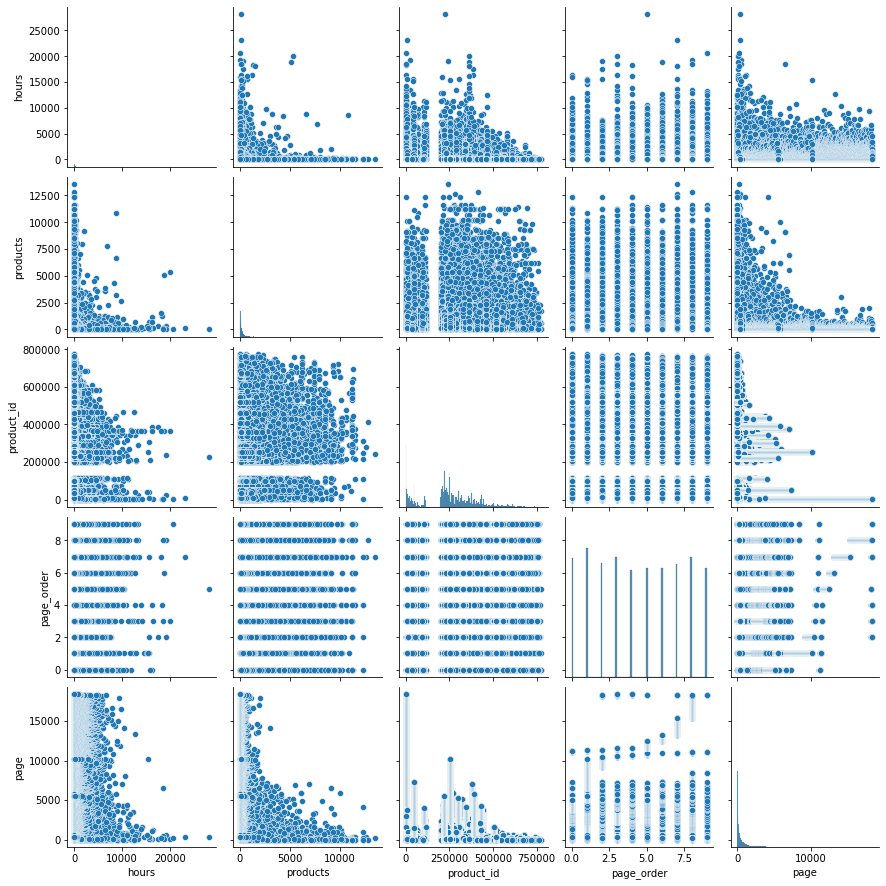

In [7]:
### vemos las ditribuciones de las variables
import seaborn as sns, numpy as np
#ax = sns.distplot(data_reviews['hours'])
dataplot = df[['hours','products','product_id','page_order','page']]
sns.pairplot(dataplot)

In [26]:
#data = data_reviews[data_reviews['product_id'].isin(data_games['id'])]
##data = data[['userId','movieId','rating']]
#data.head()
#print(data.shape)
df1 = df.copy()

In [ ]:
datax = df.groupby(['product_id'], as_index=False)['price'].count().sort_values(['price'], ascending=False)

In [43]:
datax = df1['product_id'].value_counts().head(20)
datax.head()
datax = pd.DataFrame(datax)
datax['product_top'] = datax.index
datax.rename({'product_id': 'cnt'}, axis=1, inplace=True)
datax.reset_index(drop=True, inplace=True)
datax = datax[['product_top','cnt']].sort_values(['cnt'], ascending=False)
datax.head(20)

,product_top,cnt
0,440,18373
1,252490,10221
2,49520,7321
3,377160,7113
4,271590,5976
5,391540,5710
6,230410,5518
7,620,5518
8,221100,5496
9,301520,5301


In [33]:
data_games[data_games.id == '440']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31856,Valve,"[Action, Free to Play]",Team Fortress 2,Team Fortress 2,http://store.steampowered.com/app/440/Team_For...,2007-10-10,"[Free to Play, Multiplayer, FPS, Action, Shoot...",NaN,http://steamcommunity.com/app/440/reviews/?bro...,"[Multi-player, Cross-Platform Multiplayer, Ste...",Free to Play,False,440,Valve,Very Positive,92


<AxesSubplot:xlabel='product_top', ylabel='cnt'>

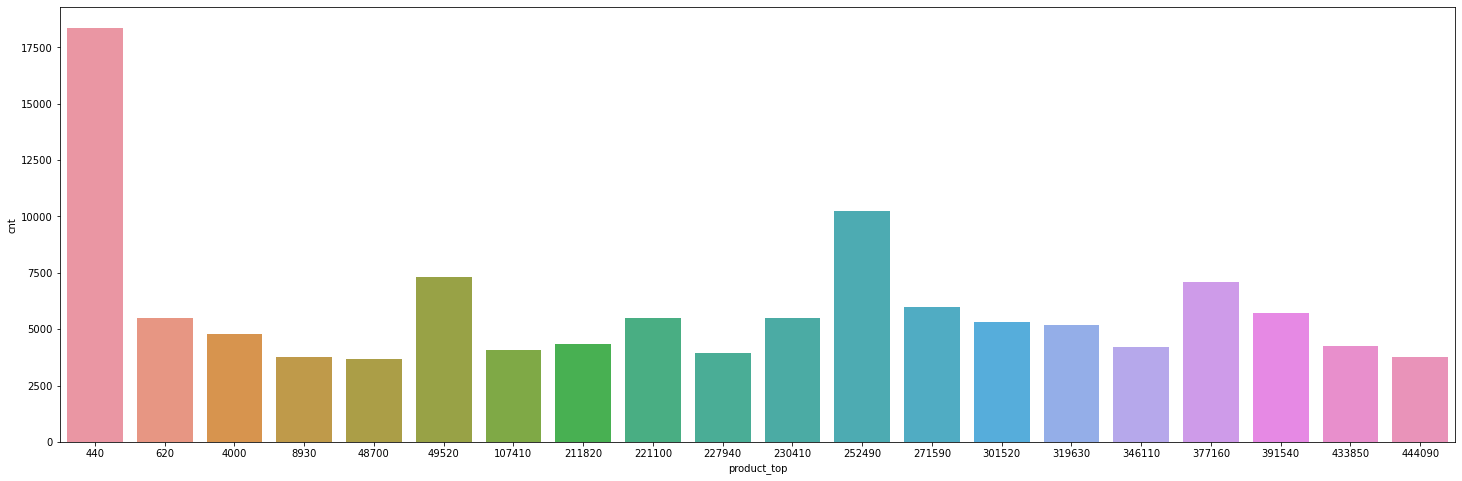

In [44]:
fig, axes = plt.subplots(1,1, figsize=(25, 8))
sns.barplot(x="product_top", y="cnt", data=datax)

In [10]:
#data_reviews_2 = data_reviews[['username','product_id']]
#data_reviews_2

In [11]:
#data_games.shape

In [12]:
#mergeado.head()

In [13]:
df[['username','product_id','title']]

,username,product_id,title
0,Chaos Syren,725280,Psi Project
1,freakfantom,725280,Psi Project
2,Ariman1,328100,Gunspell - Steam Edition
3,dll3z,328100,Gunspell - Steam Edition
4,Nyazicat,328100,Gunspell - Steam Edition
...,...,...,...
779946,rt974,518790,theHunter: Call of the Wild™
779947,Fallenglory,518790,theHunter: Call of the Wild™
779948,GooseMan,518790,theHunter: Call of the Wild™
779949,lazyboy82,518790,theHunter: Call of the Wild™


### Graficar
- Cantidad de video Juegos por usuarios
- Videos Juegos Vs Precios
- Top Juegos más vendidos

#### Cantidad de videos Juegos por usuarios

In [14]:
#mergeado.groupby(['product_id'], as_index=False)['username'].count().sort_values(['username'], ascending=False).head(10)
#data2 = df.groupby(['username'], as_index=False)['product_id'].count().sort_values(['product_id'], ascending=False)
data2 = df.groupby(['username'], as_index=False)['product_id'].count()

In [15]:
data2.rename(columns={'product_id': 'cnt_juegosxusuarios'}, inplace=True)
#data2.head(20).sort_values(['cnt_juegosxusuarios'], ascending=False).head(10)
data2.head(3)

,username,cnt_juegosxusuarios
0,!,1
1,! ZerZ,2
2,! ! ŦŕĩŽǿЯëќ™ ! !,1


In [16]:
data2.sort_values(['cnt_juegosxusuarios'], ascending=False).head(10000).describe()

,cnt_juegosxusuarios
count,10000.000000
mean,10.479700
std,9.710974
min,5.000000
25%,6.000000
50%,8.000000
75%,11.000000
max,213.000000


In [17]:
data_top = data2.sort_values(['cnt_juegosxusuarios'], ascending=False).head(10000)

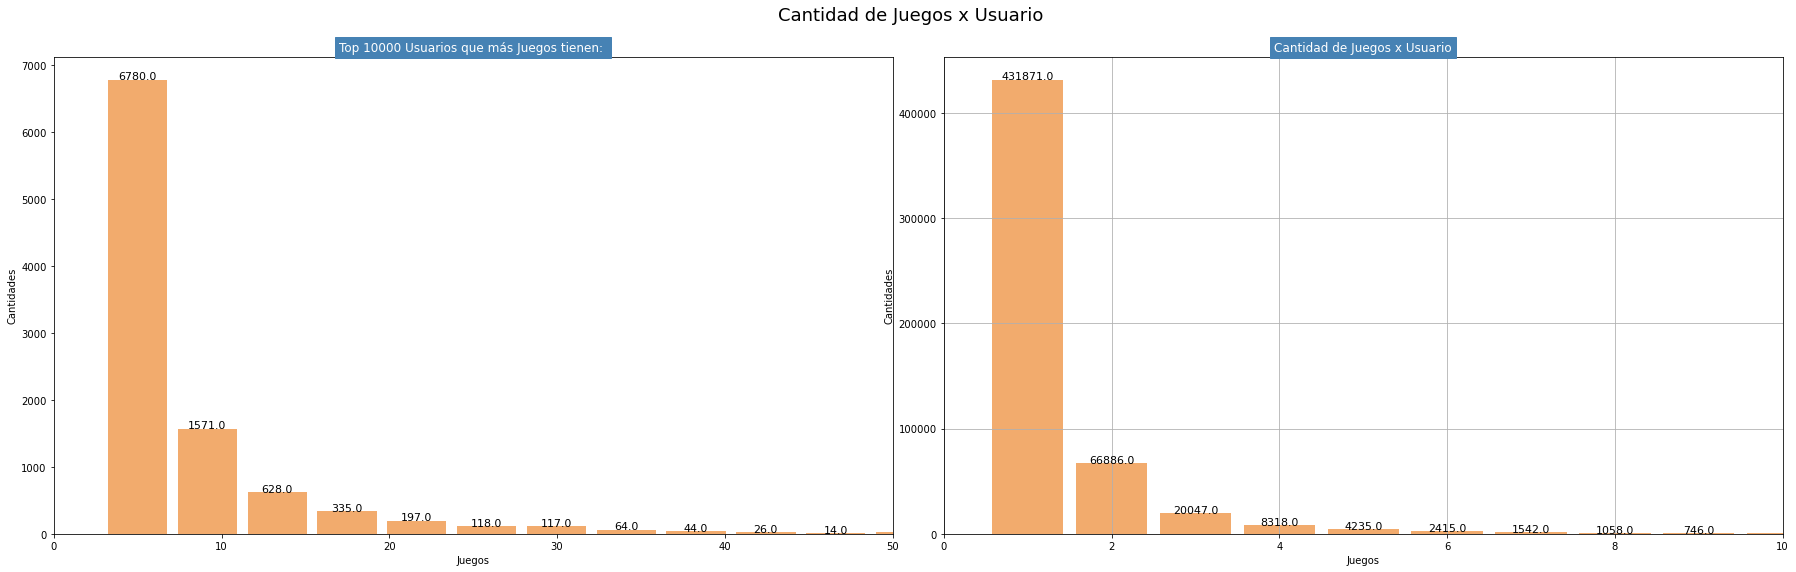

In [31]:
intervalos = range(min(data2.cnt_juegosxusuarios), max(data2.cnt_juegosxusuarios) + 2) #calculamos los extremos de los intervalos

## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Cantidad de Juegos x Usuario', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=2.0)
plt.grid()

# GRacount 0
#sns.countplot(data = df, x = "price", orient='v', order = df['price'].value_counts().index)
axes[0].set_title("Top 10000 Usuarios que más Juegos tienen: ",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[0].hist(x=data_top.cnt_juegosxusuarios, bins=50, color='#F2AB6D', rwidth=0.85, align='left')
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=45)
axes[0].set_xlabel("Juegos")
axes[0].set_ylabel("Cantidades")
axes[0].set_xlim([0,50]) ## limite en x, para acotar y quitar los outliers

count=0
for rect in axes[0].patches:
    count +=1
    if count < 12:  
#        # prints the quit message
#        #print(quit)
        axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
#    #print(count)
#    quit()#
#for rect in axes[0].patches:
##    axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
#    axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
#    if rect.get_x() == 115.552:
        
#    print("rect.get_x()", rect.get_x())
#    print("rect.get_width()", rect.get_width())
#    print("rect.get_height()", rect.get_height())


#Grafico 1
#sns.countplot(data = df, x = "pr", orient='v', ax=axes[1], order = df['property_type_2'].value_counts().index)
#axes[1].set_title("Agrupados: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[1])
#plt.xticks(rotation=45)
#plt.grid()

axes[1].set_title("Cantidad de Juegos x Usuario",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[1].hist(x=data2.cnt_juegosxusuarios, bins=intervalos, color='#F2AB6D', rwidth=0.85, align='left')
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=0)
axes[1].set_xlabel("Juegos")
axes[1].set_ylabel("Cantidades")
axes[1].set_xlim([0,10]) ## limite en x, para acotar y quitar los outliers

count=0
for rect in axes[1].patches:
    count +=1
    if count < 10:  
        axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

En el gráfico de la izaquieda observamos el top 10000 de los usuarios que han comprado más juego y su distribución. Se observa que el 67.8% ha comprado por 5 juegos, y 1.5% ha comprada 10 juegos. El gráfico de la derecha se grafica todos los datos, el 55% de los usuarios ha comprado 1 Juego, el 8.5% 2 Juegos y el 1% 3 Juegos.

#### Videos Juegos Vs Precios

In [42]:
data2 = df.groupby(['product_id'], as_index=False)['price'].count().sort_values(['price'], ascending=False)

In [43]:
data2

,product_id,price
19,440,18373
2164,252490,10221
962,49520,7321
5873,377160,7113
2630,271590,5976
...,...,...
3841,317330,0
3772,314850,0
3741,314280,0
3614,310450,0


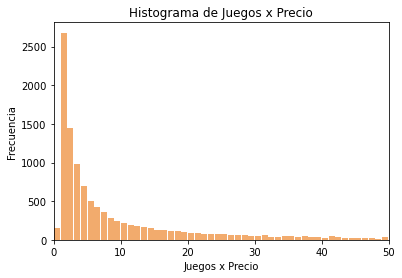

In [44]:
intervalos = range(min(data2.price.values), max(data2.price.values) + 2) #calculamos los extremos de los intervalos

plot.title('Histograma de Juegos x Precio')
#plot.hist(x=data2.cnt_juegosxusuarios, bins=intervalos, color='#F2AB6D', rwidth=0.85)
plot.hist(x=data2.price.values, bins=intervalos, color='#F2AB6D', rwidth=0.90)
plot.xlim([0, 50])
plot.xlabel('Juegos x Precio')
plot.ylabel('Frecuencia')
#plot.xticks(intervalos)
#for rect in axes[0].patches:
#    axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
plot.show()

In [45]:
intervalos

range(0, 18375)

In [82]:
mergeado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779951 entries, 0 to 779950
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   username        779933 non-null  object 
 1   product_id      779951 non-null  int64  
 2   index           779951 non-null  int64  
 3   publisher       770463 non-null  object 
 4   genres          775928 non-null  object 
 5   app_name        779951 non-null  object 
 6   title           779951 non-null  object 
 7   url             779951 non-null  object 
 8   release_date    778840 non-null  object 
 9   tags            779947 non-null  object 
 10  discount_price  1359 non-null    float64
 11  reviews_url     779951 non-null  object 
 12  specs           775923 non-null  object 
 13  price           773278 non-null  object 
 14  early_access    779951 non-null  bool   
 15  id              779951 non-null  int64  
 16  developer       774163 non-null  object 
 17  sentiment 

In [46]:
df = mergeado.dropna(subset=['price'], inplace=False)
df['price'].value_counts()

19.99           152248
Free to Play    108397
9.99            102535
14.99            84039
29.99            53355
                 ...  
1.5                  1
11.15                1
1.59                 1
1.29                 1
399.0                1
Name: price, Length: 111, dtype: int64

In [47]:
df.shape

(773278, 27)

In [48]:
#df['price'] = df['price'].astype('int')
##data_games['id'] = data_games['id'].astype('int')
#df['price'] 
df[df["price"] == "0"].price.count()

0

In [50]:
# Obtenemos los valores que toma la variable price
df['price'].unique()

array([2.99, 14.99, 9.99, 19.99, 4.99, 0.99, 5.99, 11.99, 7.99, 3.99,
       'Free to Play', 29.99, 1.99, 18.99, 8.99, 39.99, 13.99, 6.99,
       'Free To Play', 'Free', 20.0, 59.99, 12.99, 15.99, 24.99,
       'Play for Free!', 1.87, 16.99, 49.99, 17.99, 44.99, 10.99, 5.65,
       99.99, 34.99, 64.99, 0.5, 0.89, 119.99, 0.49, 10.96, 1.29, 79.99,
       189.96, 74.99, 15.0, 2.97, 4.0, 11.15,
       'Play WARMACHINE: Tactics Demo', 4.68, 12.89, 'Play the Demo',
       54.99, 31.99, 'Free Mod', 49.0, 13.98, 44.98, 74.76, 32.99, 4.49,
       189.0, 0.98, 202.76, 61.99, 13.37, 3.0, 69.99, 'Free to Use', 1.59,
       87.94, 149.99, 'Install Now', 7.49, 16.06, 3.49, 19.98,
       'Free to Try', 3.33, 23.96, 21.99, 399.99, 6.66, 1.95, 19.95,
       'Starting at $449.00', 2.49, 139.92, 199.0, 23.99, 12.0, 1.0, 9.95,
       'Third-party', 2.0, 160.91, 20.99, 10.0, 299.99, 26.99, 1.5,
       'Free Movie', 399.0, 14.95, 29.96, 771.71, 59.95, 2.3,
       'Free HITMAN™ Holiday Pack', 6.48], dtype=o

In [51]:
#lista_free = ['Free To Play','Free','Play WARMACHINE: Tactics Demo', 'Install Now','Free to Try','Free Mod','Play WARMACHINE: Tactics Demo','Free HITMAN™ Holiday Pack','Free to Play','Play the Demo','Third-party','Free Movie']
#lista_cost = ['Starting at $449.00']
lista_free = ['Free to Play','Free To Play', 'Free','Play for Free!','Play WARMACHINE: Tactics Demo','Play the Demo','Free Mod','Free to Use','Install Now','Free to Try','Third-party','Free Movie', 'Free HITMAN™ Holiday Pack']
lista_cost = ['Starting at $449.00']

In [53]:
##df.reset_index(inplace=True)
#df2 = df.loc[df['price'].isin(lista_free)]
#df2.shape
##df['price'] = df.loc[df['price'].isin(lista_free)]

Convertimos los valores que machean en la lista lista_free en 0

In [54]:
#df.loc[df['price'] == lista_free, 'price'] = '0'
#df.reset_index(inplace=True)
df.loc[df["price"].isin(lista_free), "price"] = "0"
df[df["price"] == "0"].price.count()

/home/gonperez/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


148181

Seteamos el valor de price en el valor míninmo 449 del precio de jueo para los que están en la lista_cost

In [56]:
#df.loc[df['price'] == lista_cost, 'price'] = '449'
df.loc[df["price"].isin(lista_cost), "price"] = "449"

Convierto price de object to int

In [68]:
#df.reset_index(drop=True,inplace=True)
df = df.copy()
df['price'] = df['price'].astype('int')

In [80]:
df['price'].unique()

array([  2,  14,   9,  19,   4,   0,   5,  11,   7,   3,  29,   1,  18,
         8,  39,  13,   6,  20,  59,  12,  15,  24,  16,  49,  17,  44,
        10,  99,  34,  64, 119,  79, 189,  74,  54,  31,  32, 202,  61,
        69,  87, 149,  23,  21, 399, 449, 139, 199, 160, 299,  26, 771])

In [81]:
# Creo un dataframe con los Precios de los juegos
#df_prices = df['price'].unique()
#df_p = pd.DataFrame(df_prices)
#df_p = df_p.astype('int')
#df_p.sort_values(by=0)

Distribucion de los precios de los juegos

In [83]:
#sns.distplot(df_p)
#plot.xlim([0, 3000])
#sns.histplot(df_p)

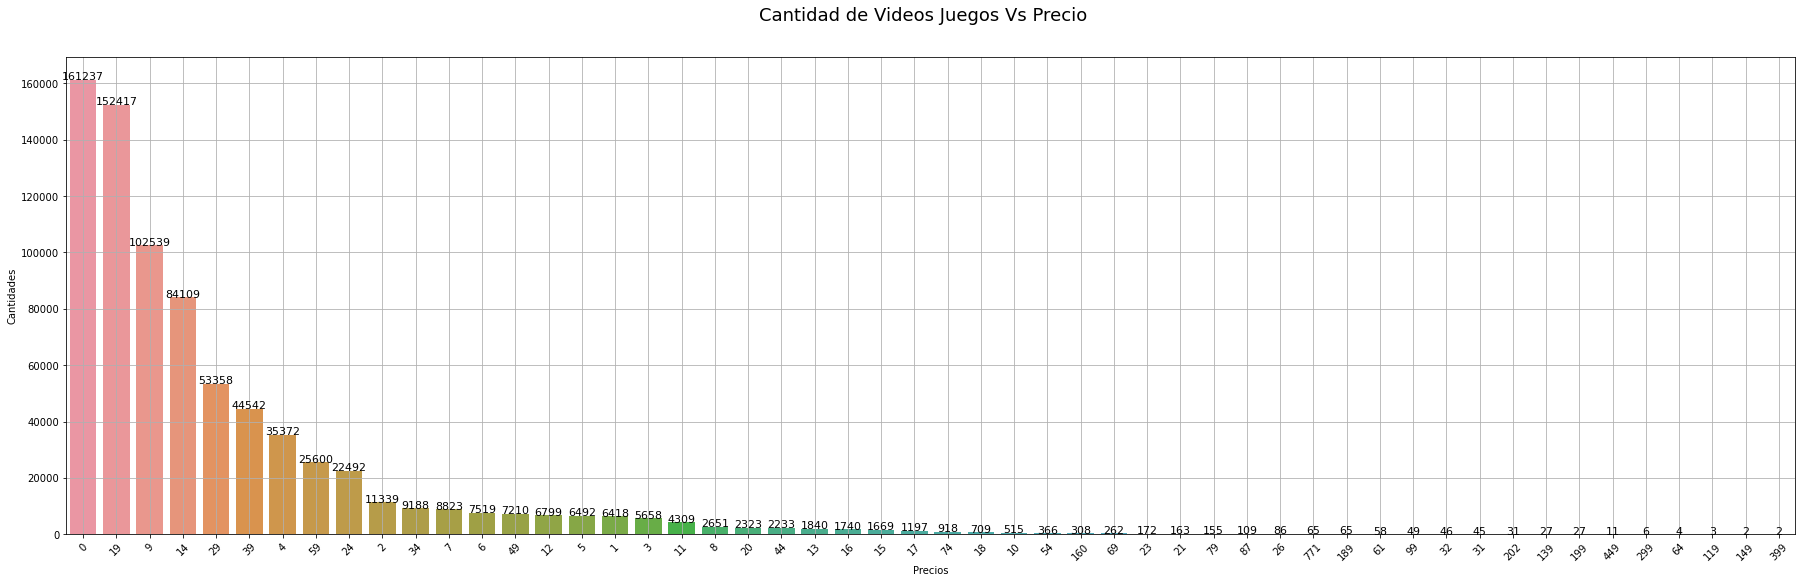

In [99]:
## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,1, figsize=(25, 8))
fig.suptitle('Cantidad de Videos Juegos Vs Precio', fontsize=18)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=2.0)

# GRacount 0
sns.countplot(data = df, x = "price", orient='v', order = df['price'].value_counts().index)
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=45)
axes.set_xlabel("Precios")
axes.set_ylabel("Cantidades")
plt.grid()

for rect in axes.patches:
    axes.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

#Grafico 1
#sns.countplot(data = df, x = "pr", orient='v', ax=axes[1], order = df['property_type_2'].value_counts().index)
#axes[1].set_title("Agrupados: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[1])
#plt.xticks(rotation=45)
#plt.grid()

#for rect in axes[1].patches:
#    axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

Se observa la ditribución de los precios de los juegos, los que figuran con valor 0, son los juegos free o demos

bineado de los precios de los juegos con rangos

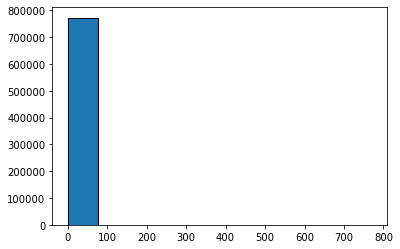

In [79]:
#create histogram with equal-width bins
n, bins, patches = plt.hist(df['price'], edgecolor='black')
plt.show()

#### Binary encoding:

In [73]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(df['price'])
#LabelBinarizer()
lb.classes_
lb.transform([1, 6])

TypeError: '<' not supported between instances of 'str' and 'float'

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 773278 entries, 0 to 779950
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   username        773260 non-null  object 
 1   hours           770681 non-null  float64
 2   products        771745 non-null  float64
 3   product_id      773278 non-null  int64  
 4   page_order      773278 non-null  int64  
 5   date            773278 non-null  object 
 6   text            771448 non-null  object 
 7   early_access_x  773278 non-null  bool   
 8   page            773278 non-null  int64  
 9   user_id         314955 non-null  float64
 10  index           773278 non-null  int64  
 11  publisher       763853 non-null  object 
 12  genres          769272 non-null  object 
 13  app_name        773278 non-null  object 
 14  title           773278 non-null  object 
 15  url             773278 non-null  object 
 16  release_date    772167 non-null  object 
 17  tags      